In [1]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
import seaborn
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

/home/junghwan/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 개요
> 정적 자산 배분 전략인 '60-40' 전략을 구현합니다.

노벨 경제학상을 받은 미국 경제학자 해리 마코위츠는 1952년에 소개한 ‘현대포트폴리오이론(MPT)’을 통해 자산을 분산투자하는 포트폴리오를 만들면, 기대수익을 최적화-극대화 하고 위험을 줄일 수 있다고 주장하였습니다. 뒤따른 여러 연구에서 비롯된 ’60/40’ 포트폴리오는 지난 수십년간 분산투자의 정석으로 꼽히고 있습니다.

--------------------------------------------------------------------------------

# 구성 요소

60-40 포트폴리오의 구성은 아래와 같습니다.

|자산군|주식|채권|
|--|--|--|
|비율|60|40|
|특징|위험자산|안전자산|

대표적인 위험자산인 주식과, 대표적인 인전자산인 채권, 상관관계가 낮은 이 두가지 자산군을 섞어 서로 보완하는 자산배분 전략으로 4~5개 이상의 자산군에 투자하는 전략에 비하면 아주 심플한 전략입니다. 이 전략은 변동성이 강한 시장에서 최적의 전략이라고 칭송받았는데 주식이 하락할때는 채권이 상승하며 주식 하락분을 메우고, 채권이 하락할 때는 주식이 상승하며 채권 하락분을 메우는 개념입니다.

특히 주식의 비율이 60%보다 커지면 변동성이 커지고, 60%보다 낮아지면 수익률이 낮아지기 때문에 리스크도 줄이면서 적정한 수익률을 거둘 수 있는 최적의 비율이라고 많은 사람들이 판단하게 되었습니다.

## 매수 매도 규칙
#### 방법 1
1. 주식시장 지수를 따르는 ETP를 60%, 장기채에 투자하는 ETF를 40% 비유로 구매합니다.
2. 주기적으로 리밸런싱을 합니다.

#### 방법 2
1. AOR이라는 ETF를 구매합니다.
2. AOR은 ETF 내에서 알아서 60/40 비율로 리밸런싱을 해주기 때문에 직접 리밸런싱 할 필요가 없습니다.
(**참고** : AOR은 ‘미국’이 아니라 ‘전 세계 주식’에 60%, ‘전 세계 채권’에 40%를 알아서 투자해주는 ETF입니다. 따라서 미국이 강세였던 최근 시장에서는 미국에 투자하는 전략에 비해 비교적 성과가 낮은 편입니다. 하지만 미국에만 투자하지 않고 글로벌 시장에 투하자기에 보다 더 안정적으로 분산하는 효과가 있습니다.)

In [2]:
# VTI(Vanguard Total Stock Market Index Fund ETF)는 미국에 상장된 모든 기업에 투자를 하는 ETF
# BND(Vanguard Total Bond Market Index Fund ETF)는 미국의 모든 채권에 골고루 투자하는 ETF
start = '2002-08-02'
end = '2021-03-11'
vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
ief = web.DataReader("IEF", 'yahoo', start, end)['Adj Close'].to_frame("ief_Close")

In [3]:
vti.head()

,vti_Close
Date,
2002-08-01,28.756369
2002-08-02,28.086744
2002-08-05,27.149929
2002-08-06,28.034681
2002-08-07,28.475317


In [4]:
ief.head()

,ief_Close
Date,
2002-08-01,46.949265
2002-08-02,47.311890
2002-08-05,47.549870
2002-08-06,47.164574
2002-08-07,47.311890


## 60:40 비율 분배

In [5]:
vti_return = vti.pct_change(periods=1)
ief_return = ief.pct_change(periods=1)
df_return = pd.concat([vti_return, ief_return], axis=1)

df_return.head()

,vti_Close,ief_Close
Date,,
2002-08-01,NaN,NaN
2002-08-02,-0.023286,0.007724
2002-08-05,-0.033354,0.005030
2002-08-06,0.032588,-0.008103
2002-08-07,0.015718,0.003123


In [6]:
df_return['6040_return'] = df_return['vti_Close']*0.6 + df_return['ief_Close']*0.4
df_return.head()

,vti_Close,ief_Close,6040_return
Date,,,
2002-08-01,NaN,NaN,NaN
2002-08-02,-0.023286,0.007724,-0.010882
2002-08-05,-0.033354,0.005030,-0.018001
2002-08-06,0.032588,-0.008103,0.016311
2002-08-07,0.015718,0.003123,0.010680


## 성과 확인

전략의 월별 수익률을 계산합니다. 이에 대한 요약은 아래와 같습니다.

- Cumulative Return :417.94%
- CAGR :  9.23%
- MDD :  -12.71
- Sharpe : 0.87
- Sortino : 1.24

## 장점

4~5개 이상의 자산군에 투자하는 경우, 각 자산군별 어떤 주식에 투자할지 선택해야 하고, 선택한 주식을 따로따로 구매해야 합니다. 그리고 중간 중간 자산군별 비중을 확인하여 리밸런싱 해주어야 하는데, 이러한 절차를 단 2개의 자산군으로 간단하게 할 수 있다는 것이 큰 장점입니다. 복잡한게 싫고 쉽고 단순하게 자산배분을 하고 싶은 투자자들에게 딱이라고 할 수 있습니다. 심지어 AOR이라는 ETF는 알아서 리밸런싱까지 해주며, 최근 몇 년 전부터 전문가들이 이 전략에 대한 한계점을 제시하고 있긴 하지만 아직까지도 괜찮은 성과를 내고 있는 전략입니다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


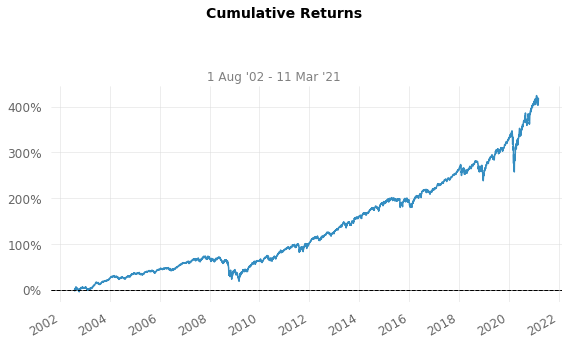

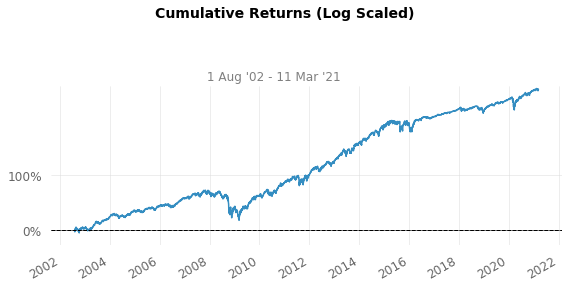

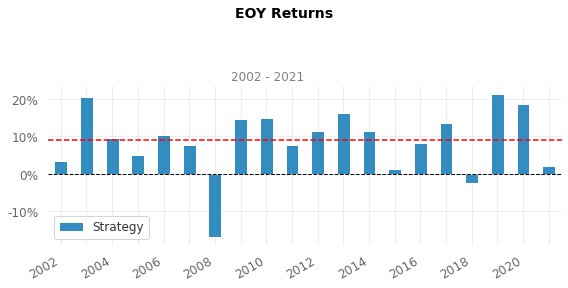

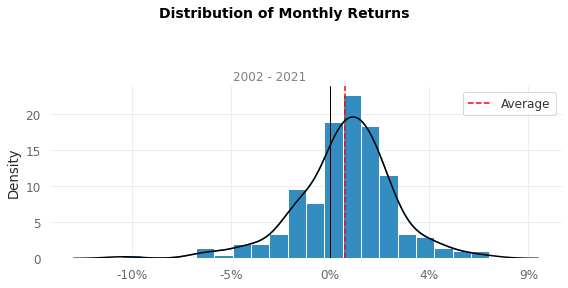

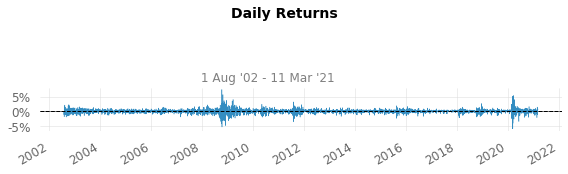

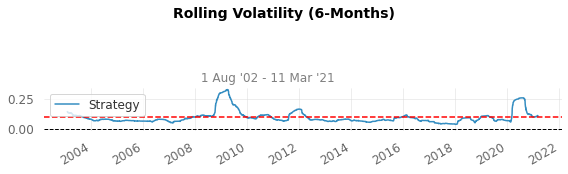

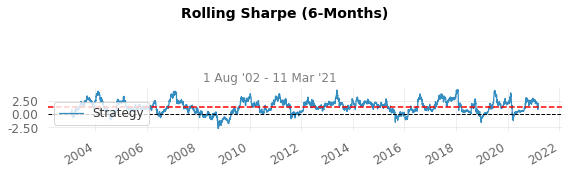

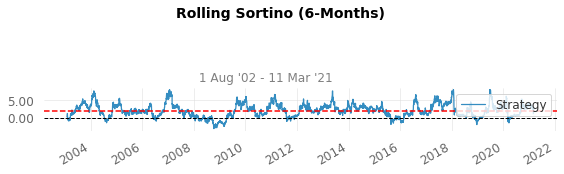

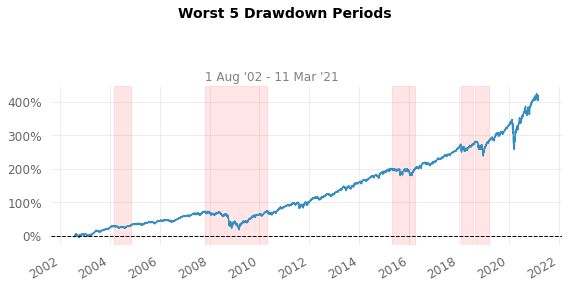

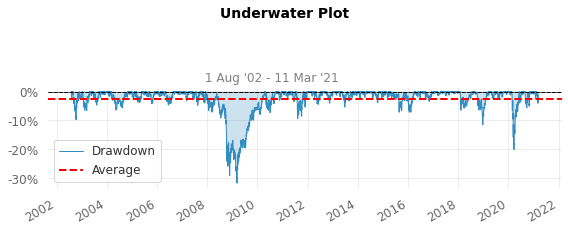

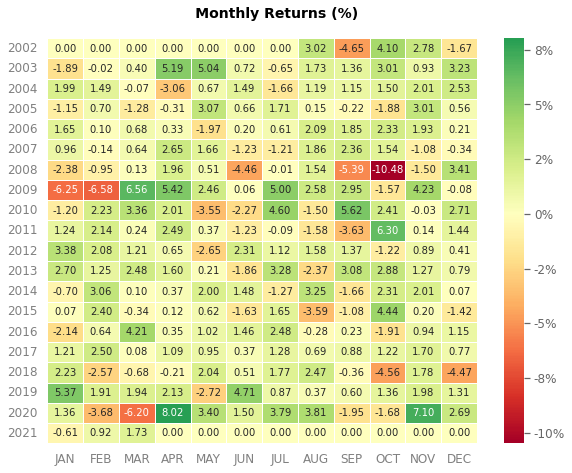

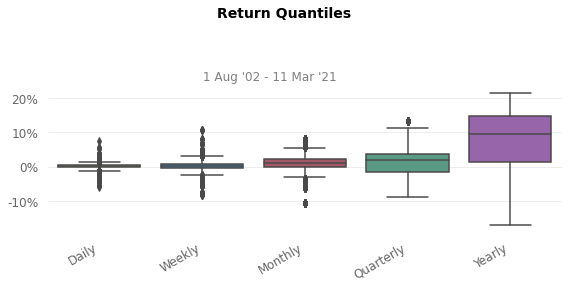

In [7]:
quantstats.reports.plots(df_return['6040_return'], mode='full')

In [8]:
quantstats.reports.html(df_return['6040_return'], 'SPY')

## 한계점

#### 1. 초저금리 시대

60/40 전략이 지금까지 좋은 성과를 보여준 이유는 주식과 함께 채권의 수익률까지 좋았기 때문입니다. 하지만 앞으로는 저금리 시대로 채권이 과거만큼 좋은 수익율이 나오지 않고 주식의 가격이 하락할 때 헷지를 하지 못할 확률이 높습니다.

#### 2. 인플레이션에 약함

물가가 상승하는 시기에는 주식과 채권이 모두 하락하게 됩니다. 60/40전략은 주식과 채권이 전부이기 때문에, 인플레이션이 오면 방어할 수 없습니다.

#### 3. 비교적 높은 MDD(전고점 대비 최대 낙폭)

주식에 몰빵하는 전략보다 MDD가 낮지만, 더 많은 자산군에 투자하는 자산배분 전략들과 비교해 약간 더 높습니다.
만약 위험을 감수할 수 있는 정도가 낮은 보수적인 투자자이거나, 앞으로 투자가 가능한 기간이 얼마 남지 않는 투자자에게는 적합하지 않습니다.